In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from math import *
from scipy import special

In [2]:
data1 = pd.read_excel('cyexcel.xlsx',sheet_name = 'Sheet1')
data2 = pd.read_excel('cyexcel.xlsx',sheet_name = 'Sheet2')
data1 = data1.set_index('Time')
data2 = data2.set_index('Time')
df = data1.join(data2,how = 'left')
df.reset_index(inplace = True)


## Global Variables

In [3]:
k = 200
phi = 0.25
mew = 0.55
c = 7 * 10**(-6)
ro = 9200
h = 100
Bw = 1.0
cf = 4 *10**(-6)
cw = 3 * 10**(-6)
f = 140/360

N = 312 * 10**6
Swc = 0.05
U = 1.119 *f* phi *h*c*ro**2

In [4]:
def tde(t):
    k = 200
    phi = 0.25
    mew = 0.55
    c = 7 * 10**(-6)
    ro = 9200
    
    return (2.309*k*t)/(phi*mew*c*ro**2)

In [5]:
def csch(rD) :
    return 2/((e**rD)-(e**-rD))

## Finite case

In [6]:
def finite_qd(tde,rD): 
    tD = tde
    #for alpha 1
    b0 = -0.00222107
    b1 = -0.627638
    b2 = 6.277915
    b3 = -2.734405
    b4 = 1.2708
    b5 = -1.100417
    a1 = b0+b1*csch(rD)+b2*(rD**b3)+b4*(rD**b5)

    
    #for alpha 2
    b0 = -0.00796608
    b1 = -1.85408
    b2 = 18.71169
    b3 = -2.758326
    b4 = 4.829162
    b5 = -1.009021
    a2 = b0+b1*csch(rD) +b2*(rD**b3)+b4*(rD**b5)

    
    #Calculate qD
    bes_0_1 = special.j0(a1)
    bes_1_1 = special.j1(a1*rD)
    bes_0_2 = special.j0(a2)
    bes_1_2 = special.j1(a2*rD)
    qD1 = ((rD**2)-1)/2
    qD2 = (2*math.e**((-a1**2)*tD) *bes_1_1**2) / ((a1**2)*bes_0_1**2 - bes_1_1**2)

    qD3 = (2*math.e**((-a2**2)*tD) *(bes_1_2)**2) / ( (a1**2)*(bes_0_2**2)- bes_1_2**2) 
    qD = qD1 - qD2 - qD3
    
    return qD  

# Infinte Case

In [7]:
def infinite_qde(tD):
    qD = None
    if tD < 200 and 0.01<tD:
        b0 = 1.129552
        b1 = 1.160436
        b2 = 0.2642821
        b3 = 0.01131791
        b4 = 0.5900113
        b5 = 0.04589742
        b6 = 1.00
        b7 = 0.5002034
        b8 = 1.500
        b9 = 1.979139

        qD = (b0*(tD**b7)+b1*(tD)+b2*(tD**b8)+b3*(tD**b9))/(b4*(tD**b7)+b5*(tD)+b6)

    elif tD< 0.01:
        qD = (2 * tD**0.5)/math.pi ** 0.5
        
        
    #for 200-<tD<2.0*10^12
    elif tD< 2*10**12 and tD>= 200 :
        b0 = 4.39880
        b1 = 0.43693
        b2 = -4.16078
        b3 = 0.090
        qD = 10**(b0+b1* math.log(tD)+b2*((math.log(tD))**b3) )
                  
    return qD

## Tcross

In [8]:
def tcross(rD):
    b0 = -1.767
    b1 = -0.606
    b2 = 0.12368
    b3 = 3.02
    b4 = 2.25
    b5 = 0.5
    rD = 5
    ans = b0+b1*rD+b2*((rD)**b4)+b3*(math.log(rD))**b5
    return ans

# Step 3

In [9]:
def step3(tD,rD):
    tcros = tcross(rD)
    if tcros > tD:
        ans = infinite_qde(tD)
    else :
        ans = finite_qd(tD,rD)
        
    return ans

In [10]:
def wde(df):
    for i in range(1,len(df)):
        wde = 0
        for j in range(i):
            wde += (df.loc[j,'delta p'] * df.loc[i-j,'wd']   )
        df.loc[i,'We'] = U * wde
    return df

In [11]:
def accessories(df):    
    df['F'] = df['Np']*(df['Bo']+(df['Rp']-df['Rs'])*df['Bg'])
    df['Eo'] = (df['Bo']-df.loc[0,'Bo'])+(df.loc[0,'Rs'] - df['Rs'])*df['Bg']
    df['f\eo'] = df['F']/df['Eo']
    df['wd/eo'] = df['We']/df['Eo']
    return df

In [12]:
df['tde'] = df['Time'].apply(tde)


In [13]:
rD =10

In [14]:
df['wd'] = df['tde'].apply(lambda x : step3(x,rD))

In [15]:
df

,Time,Pressure OWC,Plateau pressure,delta p,Np,Rp,Bo,Rs,Bg,tde,wd
0,0,2740,NaN,120.0,NaN,650,1.404,650,0.00093,0.000000,0.000000
1,1,2500,2620.0,225.0,7.88,760,1.374,592,0.00098,5.668622,52.021509
2,2,2290,2395.0,196.0,18.42,845,1.349,545,0.00107,11.337245,51.477603
3,3,2109,2199.0,170.0,29.15,920,1.329,507,0.00117,17.005867,51.253656
4,4,1949,2029.0,146.0,40.69,975,1.316,471,0.00128,22.674490,51.114370
5,5,1818,1883.0,123.0,50.14,1025,1.303,442,0.00139,28.343112,51.001495
6,6,1702,1760.0,105.0,58.42,1065,1.294,418,0.00150,34.011735,50.900339
7,7,1608,1655.0,84.0,65.39,1095,1.287,398,0.00160,39.680357,50.806942
8,8,1635,1571.0,64.0,70.74,1120,1.280,383,0.00170,45.348980,50.720007
9,9,1480,1507.0,47.0,74.54,1145,1.276,381,0.00176,51.017602,50.638912


In [16]:
df = wde(df)

In [17]:
df

,Time,Pressure OWC,Plateau pressure,delta p,Np,Rp,Bo,Rs,Bg,tde,wd,We
0,0,2740,NaN,120.0,NaN,650,1.404,650,0.00093,0.000000,0.000000,NaN
1,1,2500,2620.0,225.0,7.88,760,1.374,592,0.00098,5.668622,52.021509,4.023773e+07
2,2,2290,2395.0,196.0,18.42,845,1.349,545,0.00107,11.337245,51.477603,1.152628e+08
3,3,2109,2199.0,170.0,29.15,920,1.329,507,0.00117,17.005867,51.253656,1.800224e+08
4,4,1949,2029.0,146.0,40.69,975,1.316,471,0.00128,22.674490,51.114370,2.359062e+08
5,5,1818,1883.0,123.0,50.14,1025,1.303,442,0.00139,28.343112,51.001495,2.836939e+08
6,6,1702,1760.0,105.0,58.42,1065,1.294,418,0.00150,34.011735,50.900339,3.237624e+08
7,7,1608,1655.0,84.0,65.39,1095,1.287,398,0.00160,39.680357,50.806942,3.578142e+08
8,8,1635,1571.0,64.0,70.74,1120,1.280,383,0.00170,45.348980,50.720007,3.848497e+08
9,9,1480,1507.0,47.0,74.54,1145,1.276,381,0.00176,51.017602,50.638912,4.052295e+08


In [18]:
df = accessories(df)

In [19]:
df

,Time,Pressure OWC,Plateau pressure,delta p,Np,Rp,Bo,Rs,Bg,tde,wd,We,F,Eo,f\eo,wd/eo
0,0,2740,NaN,120.0,NaN,650,1.404,650,0.00093,0.000000,0.000000,NaN,NaN,0.00000,NaN,NaN
1,1,2500,2620.0,225.0,7.88,760,1.374,592,0.00098,5.668622,52.021509,4.023773e+07,12.124483,0.02684,451.731863,1.499170e+09
2,2,2290,2395.0,196.0,18.42,845,1.349,545,0.00107,11.337245,51.477603,1.152628e+08,30.761400,0.05735,536.380122,2.009813e+09
3,3,2109,2199.0,170.0,29.15,920,1.329,507,0.00117,17.005867,51.253656,1.800224e+08,52.825921,0.09231,572.266510,1.950194e+09
4,4,1949,2029.0,146.0,40.69,975,1.316,471,0.00128,22.674490,51.114370,2.359062e+08,79.797973,0.14112,565.461825,1.671671e+09
5,5,1818,1883.0,123.0,50.14,1025,1.303,442,0.00139,28.343112,51.001495,2.836939e+08,105.964372,0.18812,563.280735,1.508047e+09
6,6,1702,1760.0,105.0,58.42,1065,1.294,418,0.00150,34.011735,50.900339,3.237624e+08,132.292090,0.23800,555.849118,1.360346e+09
7,7,1608,1655.0,84.0,65.39,1095,1.287,398,0.00160,39.680357,50.806942,3.578142e+08,157.079858,0.28620,548.846464,1.250224e+09
8,8,1635,1571.0,64.0,70.74,1120,1.280,383,0.00170,45.348980,50.720007,3.848497e+08,179.177346,0.32990,543.126238,1.166565e+09
9,9,1480,1507.0,47.0,74.54,1145,1.276,381,0.00176,51.017602,50.638912,4.052295e+08,195.342506,0.34544,565.488958,1.173082e+09


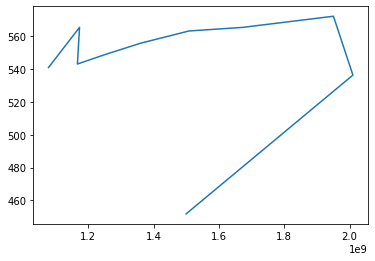

In [20]:
plt.plot(df['wd/eo'],df['f\eo'])

In [21]:
tcross(5)

3.657899879898163